**This notebook is in Python 2.7**

In [1]:
!pip install pattern

You are using pip version 9.0.3, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from pattern.en import parsetree
import pickle

In [11]:
# Helper functions for pickling
def send_pickle(obj, file_name):
    f = open(file_name,"wb")
    pickle.dump(obj, f)
    f.close()
    
def open_pickle(file_name):
    f = open(file_name,"rb")
    t = pickle.load(f)
    f.close()
    return t

In [4]:
df = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/fake_or_real_news.csv")
print(df.shape)
print("Number of fakes: ",df[df['label'].str.contains("FAKE")].shape[0])
df = df[['title','text','label']]
df.head()

(6335, 4)
('Number of fakes: ', 3164)


,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


# 1. Is fake/real news distinguishable by sentence structure? 
The purpose of this question is to help humans naturally distinguish fake from real news by solely reading a news headline (with reasonable degree of error). In the field of linguistics, there's a lot of variability between how a sentence is actually structured, its word choice, and how these factors convey "real" or "fake" content. In this analysis we attempt to see if there is a quantifiable difference between fake and real news headlines using simple metrics.

*Note (warning): running the notebook produces different plots below, but the relative results are essentially the same*

**Parse headlines into linguistic parse trees**

In [5]:
df['title_chunks'] = df[['title']].apply(lambda x: [chunk.type for chunk in parsetree(x['title'])[0].chunks], axis=1)
df.head()

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/pattern/text/__init__.py:979: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  and tokens[j] in ("'", "\"", u"”", u"’", "...", ".", "!", "?", ")", EOS):


,title,text,label,title_chunks
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,"[NP, VP, NP]"
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,"[NP, VP, NP, PP, NP, NP]"
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,"[NP, VP, NP, PP, NP, PP, NP]"
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,"[NP, PP, NP, VP, PP, NP, PP, NP, NP, VP, NP]"
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,"[NP, PP, NP, NP]"


## Analyze similarity of sentence structure of headlines

In [ ]:
import numpy as np
import difflib

#This was run once and then m was saved as a file since it took a long time (not seen in git remote)
chunks = df['title_chunks'].tolist()
m = np.zeros((df.shape[0], df.shape[0]))
for i, chunkx in enumerate(chunks):
    for j, chunky in enumerate(chunks):
        m[i][j] = difflib.SequenceMatcher(None,chunkx,chunky).ratio()
        
np.save("similarity_matrix",m)

In [6]:
m = np.load("similarity_matrix.npy") 

In [7]:
#reduce dimensionality of sim matrix to 2
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)

In [8]:
tsne = tsne_model.fit_transform(m)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6335
[t-SNE] Computed conditional probabilities for sample 2000 / 6335
[t-SNE] Computed conditional probabilities for sample 3000 / 6335
[t-SNE] Computed conditional probabilities for sample 4000 / 6335
[t-SNE] Computed conditional probabilities for sample 5000 / 6335
[t-SNE] Computed conditional probabilities for sample 6000 / 6335
[t-SNE] Computed conditional probabilities for sample 6335 / 6335
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.063915
[t-SNE] Error after 300 iterations: 1.063915


In [ ]:
# Optional for running notebook again
tsne = open_pickle("tsne.pckl")

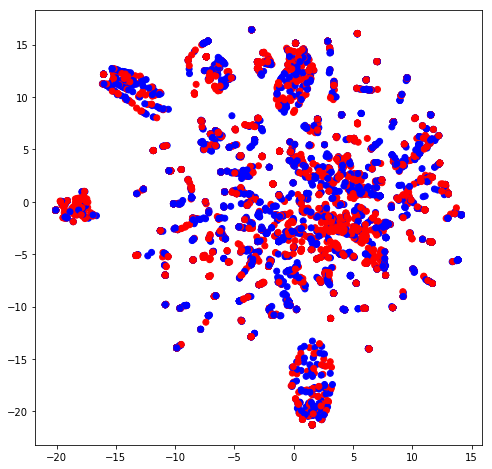

In [15]:
colors = {'FAKE':'red','REAL':'blue'}
plt.figure(figsize=(8,8))
plt.scatter(tsne[:,0],tsne[:,1],c=df['label'].apply(lambda x: colors[x]))

We visualize our TSNE distances of sentence tree structures as a means of qualitatively evaluating different news headline sentence structure. We see that there isn't a clear cluster of blue cells and red cells, so fake news headlines often have very similar structures to that of real news, and vice versa. 
A more objective way of determining the "apart-ness" of this metric would be using something like gap distance or even looking at the error of a KNN classifier. However, we believe this graph is sufficient to show that sentence structure would probably not be a definitive heuristic for humans to use.

## Analyze similarity of headlines through word frequencies
The above process is repeated using different data, where we use word frequencies in each headline to gauge similarities.

In [16]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
titles_tfidf = tfidf_vectorizer.fit_transform(df['title'])
tfidf_df = pd.DataFrame(titles_tfidf.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df.head()

,00,000,00pm,01,04,05,06,08,10,100,...,آمریکا,ارزی,القادمون,ایران,جنگ,سال,علیه,مطالعاتی,مورد,کدآمایی
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
tsne_tfidf_model = TSNE(n_components=2, verbose=1, random_state=0)

In [18]:
tsne_tfidf = tsne_tfidf_model.fit_transform(tfidf_df)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6335
[t-SNE] Computed conditional probabilities for sample 2000 / 6335
[t-SNE] Computed conditional probabilities for sample 3000 / 6335
[t-SNE] Computed conditional probabilities for sample 4000 / 6335
[t-SNE] Computed conditional probabilities for sample 5000 / 6335
[t-SNE] Computed conditional probabilities for sample 6000 / 6335
[t-SNE] Computed conditional probabilities for sample 6335 / 6335
[t-SNE] Mean sigma: 0.471306
[t-SNE] KL divergence after 75 iterations with early exaggeration: 1.011454
[t-SNE] Error after 100 iterations: 1.011454


In [19]:
send_pickle(tsne_tfidf, "tsne_tfidf.pckl")

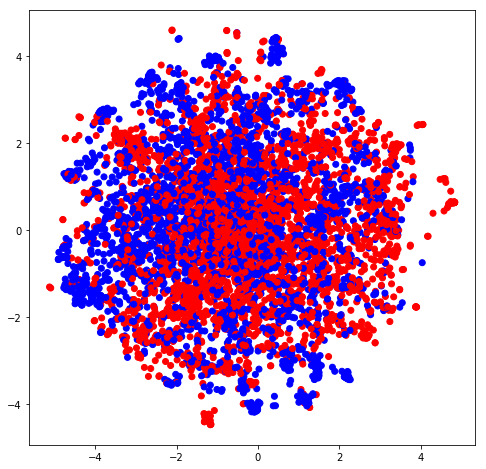

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(tsne_tfidf[:,0],tsne_tfidf[:,1],c=df['label'].apply(lambda x: colors[x]))

Again, we see no definitive separation with just 2 dimensions, but we can see a clearer separation between the fake and real news headlines.

This is a more interesting result and can be explored further in the next analysis question.

# 2. What are the words most associated with or targets of fake news? Could we generate additional features from this analysis to make a comparable classifier? 

In [25]:
linear_clf = pickle.load(open('PAC_model.pckl', 'rb'))
tfidf_vectorizer = pickle.load(open('tfidf_vectorizer.pckl', 'rb'))

labels = linear_clf.classes_
feature_names = tfidf_vectorizer.get_feature_names()
word_freqs = sorted(zip(linear_clf.coef_[0], feature_names))

print("Label", "Frequency", "Word")
for coef, feat in word_freqs[:50]:
    print(labels[0], coef, str(feat))

for coef, feat, in word_freqs[-50:]:
    print(labels[0], coef, str(feat))

ValueError: unsupported pickle protocol: 3

# 3. Which encoding works better to classify fake news? TF-IDF or word2vec?

In [99]:
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [100]:
# Split into training and test sets
# Load the punkt tokenizer used for splitting reviews into sentences
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,title,text,label,class
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


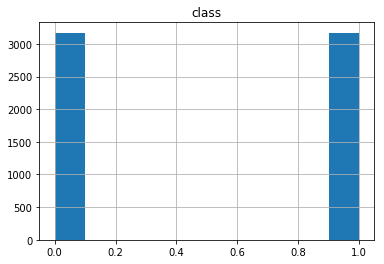

In [101]:
df = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/fake_or_real_news.csv")
df['class'] = 1 * (df['label'].str.contains("REAL"))
df.hist('class')
df.head()

In [102]:
#df.sort_values('Unnamed: 0', axis=0, inplace=True)
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size,:]
test_df = df.iloc[train_size:,:]

In [103]:
print('Training set contains {:d} articles.'.format(len(train_df)))
print('Test set contains {:d} articles.'.format(len(test_df)))

Training set contains 5068 articles.
Test set contains 1267 articles.


In [104]:
n_real_train = sum(train_df['class'] == 1)
print('Training set contains {:d} REAL out of {:d} articles'.format(n_real_train,len(train_df)))
n_real_test = sum(test_df['class'] == 1)
print('Test set contains {:d} REAL out of {:d} articles'.format(n_real_test,len(test_df)))
train_df.head()

Training set contains 2548 REAL out of 5068 articles
Test set contains 623 REAL out of 1267 articles


,Unnamed: 0,title,text,label,class
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


In [105]:
del df #clean up

In [106]:
# Convert an article to a list of words.
def article_to_wordlist(article, remove_stopwords=False):
    # remove non-letters
    article_text = re.sub("[^a-zA-Z]"," ", article)
    
    # convert to lower case and split at whitespace
    words = article_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

In [107]:
# Split article into list of sentences where each sentence is a list of words.
def article_to_sentences(article, tokenizer, remove_stopwords=False):
    # use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(article.strip())

    # each sentence is furthermore split into words
    sentences = []    
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            sentences.append(article_to_wordlist(raw_sentence, remove_stopwords))
            
    return sentences

In [108]:
train_df.head()

,Unnamed: 0,title,text,label,class
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


In [109]:
train_sentences = []  # Initialize an empty list of sentences
for article in train_df['text']:
    train_sentences += article_to_sentences(article, tokenizer)

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 12: ordinal not in range(128)